In [2]:
from aia_ops.aia_simu import get_aia_simu


import numpy as np
import cupy as cp
import cupyx.scipy.signal as signal
import scipy
from scipy.optimize import curve_fit
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from astropy.modeling import models, fitting
import astropy.units as u
from astropy import constants as const
from astropy.stats import gaussian_sigma_to_fwhm,gaussian_fwhm_to_sigma

import datetime
import pickle
import importlib
import json
import time
import glob

In [2]:
with open('aia_ops\data\\aia.pkl','rb' ) as f:
    aia_data_df=pickle.load(f)

with open('eve_ops/data/daily_df.pkl','rb' ) as f:
    eve_data_df=pickle.load(f)

eve_data_df.reset_index(inplace=True)

In [17]:
aia_data_df.iloc[0]['time'].date()

datetime.date(2010, 6, 1)

<module 'aia_ops.aia_simu' from 'D:\\py_repo\\EVE-spectrum-correction\\Chapter4_v2\\basic_ops\\aia_ops\\aia_simu.py'>

In [14]:
t0=pd.to_datetime('2012-06-09 00:00:00')
t1=pd.to_datetime('2013-01-25 00:00:00')
aia_df=aia_ops.aia_simu.get_aia_simu(aia_data_df,t0,t1)
aia_df.set_index('time',inplace=True)
eve_df=eve_data_df[(eve_data_df['time']>=t0)&(eve_data_df['time']<=t1)].reset_index(drop=True)
eve_df.set_index('time',inplace=True)

In [225]:
def plot(aia_df,eve_df):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=.011)

    valid_day=np.where(eve_df['available_data']>=np.nanmean(eve_df['available_data'])*0.2,1,np.nan)
    x = eve_df.index
    y_median = eve_df['median_of_mean']*valid_day
    y_stddev = eve_df['stddev_of_mean']
    fill_x = np.concatenate([x, x[::-1]])
    fill_y = np.concatenate([y_median + 3 * y_stddev, (y_median - 3 * y_stddev)[::-1]])

    # EVE: Plot the mean line
    fig.add_trace(go.Scatter(x=x, y=y_median,
                                  # showlegend=False, 
                            line=dict(color='rgb(0,128,255)', ),
                            name='EVE') ,
                row=3, col=1,)
    # Plot the shaded area between mean + 3 std deviations and mean - 3 std deviations
    fig.add_trace(go.Scatter(x=fill_x, y=fill_y, mode='lines', 
                                  fill='tozerox', 
                                  fillcolor='rgba(0,176,246,0.2)',
                                  line=dict(color='rgba(127,255,0,0.2)'),
                                  showlegend=False, 
                                  name='3 Std. Dev.'),
                row=3, col=1)
    #AIA
    fig.add_trace(go.Scatter(x=aia_df.index, y=aia_df['mean'],
                            # showlegend=False, 
                      line=dict(color='rgb(255,128,53)'),
                                  name='AIA') ,
                row=3, col=1,)

    fig.update_yaxes(title_text="Mean (nm)",range=[30.3705, 30.3755],row=3, col=1)
    # Show the plot



    # Create a figure for stddev
    x = eve_df.index
    y_median = eve_df['median_of_stddev']*valid_day
    y_stddev = eve_df['stddev_of_stddev']
    fill_x = np.concatenate([x, x[::-1]])
    fill_y = np.concatenate([y_median + 3 * y_stddev, (y_median - 3 * y_stddev)[::-1]])

    fig.add_trace(go.Scatter(x=x, y=y_median,
                                  showlegend=False,
                            line=dict(color='rgb(0,128,255)'),),
                            row=2, col=1)
    # Plot the shaded area between mean + 3 std deviations and mean - 3 std deviations
    fig.add_trace(go.Scatter(x=fill_x, y=fill_y, mode='lines', 
                                  fill='tozerox', 
                                  fillcolor='rgba(0,176,246,0.2)',
                                  line=dict(color='rgba(127,255,0,0.2)'),
                                  showlegend=False,
                                  name='3 Std. Dev.'),
                      row=2, col=1)
    #AIA
    fig.add_trace(go.Scatter(x=aia_df.index, y=aia_df['stddev'],
                            showlegend=False, 
                      line=dict(color='rgb(255,128,53)', )) ,
                row=2, col=1,)
    fig.update_yaxes(title_text="Stddev (nm)",
                     range=[0.028, 0.033],
                     row=2, col=1)





    # # Create a figure for amplitude
    x = eve_df.index
    y_median = eve_df['median_of_amplitude']*valid_day
    y_stddev = eve_df['stddev_of_amplitude']
    fill_x = np.concatenate([x, x[::-1]])
    fill_y = np.concatenate([y_median + 3 * y_stddev, (y_median - 3 * y_stddev)[::-1]])


    fig.add_trace(go.Scatter(x=eve_df.index, y=y_median/np.nanmean(y_median),
                                              showlegend=False,
                            line=dict(color='rgb(0,128,255)'),),
                            row=1, col=1)
    # Plot the shaded area between mean + 3 std deviations and mean - 3 std deviations
    fig.add_trace(go.Scatter(x=fill_x, y=fill_y/np.nanmean(y_median), mode='lines', 
                                  fill='tozerox', 
                                  fillcolor='rgba(0,176,246,0.2)',
                                  line=dict(color='rgba(127,255,0,0.2)'),
                                  showlegend=False, 
                                  name='3 Std. Dev.'),
                            row=1, col=1)
    #AIA
    fig.add_trace(go.Scatter(x=aia_df.index, y=aia_df['amplitude']/np.nanmean(aia_df['amplitude']),
                            showlegend=False, 
                      line=dict(color='rgb(255,128,53)', )) ,
                row=1, col=1,)
    fig.update_yaxes(title_text='relative amplitude ',
                      # range=[0.6, 1.4],
                      row=1, col=1)



    # total fig adjustment
    fig.update_layout(width=1200,height=1200,
                            title_text=f"EVE AIA",
                            legend=dict(x=1, y=0.9)) 
    fig.update_xaxes(title_text="Time",row=3, col=1)

    fig.write_html('output/fig.html')

In [226]:
def combine_trial(aia_data_df,eve_data_df,t0,t1):
    aia_df=aia_ops.aia_simu.get_aia_simu(aia_data_df,t0,t1)
    aia_df.set_index('time',inplace=True)
    eve_df=eve_data_df[(eve_data_df['time']>=t0)&(eve_data_df['time']<=t1)].reset_index(drop=True)
    eve_df.set_index('time',inplace=True)
    
    plot(aia_df,eve_df)

## endless trial and adjustment

In [256]:
import aia_ops
importlib.reload(aia_ops.aia_simu)

<module 'aia_ops.aia_simu' from 'D:\\py_repo\\EVE-spectrum-correction\\Chapter4_v2\\basic_ops\\aia_ops\\aia_simu.py'>

In [257]:
t0=pd.to_datetime('2012-07-01 00:00:00')
t1=pd.to_datetime('2013-01-01 00:00:00')


combine_trial(aia_data_df,eve_data_df,t0,t1)

In [258]:
t0=pd.to_datetime('2010-05-01 00:00:00')
t1=pd.to_datetime('2014-05-01 00:00:00')

combine_trial(aia_data_df,eve_data_df,t0,t1)

# draft

In [80]:
u

<module 'astropy.units' from 'C:\\Users\\14902\\anaconda3\\envs\\sdo2022\\lib\\site-packages\\astropy\\units\\__init__.py'>

In [97]:
(3000*u.m/u.s ).to(u.nm, equivalencies=u.doppler_optical(30.3783 * u.nm))-30.3783* u.nm

<Quantity 0.00030399 nm>

In [73]:
#15'   ~     0.014   Tx 前面的系数


0.014*(1/(15*np.pi/(180*60)))**2 *gaussian_fwhm_to_sigma



# 4e-3    ~    DN 1000    image 前面的系数


312.2738079091585

In [127]:
def doppler_shift(velocity, wavelength=30.38e-9):

    c = 3e8
    
    # Calculate Doppler shift using formula: Doppler shift = velocity / c * wavelength
    doppler_shift = velocity / c * wavelength
   
    return doppler_shift

doppler_shift(40e3)

4.050666666666667e-12

In [ ]:
#   


In [120]:
def velocity_from_doppler_shift(doppler_shift, wavelength=30.38e-9):

    c = 3e8
    
    # Calculate velocity using formula: Velocity = Doppler shift * c / wavelength
    velocity = doppler_shift * c / wavelength
    
    return velocity

# Example usage:
doppler_shift_input = 0.001e-9  # Angstroms
calculated_velocity = velocity_from_doppler_shift(doppler_shift_input)
calculated_velocity

9874.917709019091

In [125]:
velocity_from_doppler_shift(0.005e-9)

49374.58854509545

In [124]:
14*gaussian_fwhm_to_sigma

5.945252602016134

In [ ]:
0.005

In [196]:
8e2*(0.25*np.pi/180)**2

0.015230870989335428

In [199]:
30e-1*(0.25*np.pi/180)

0.013089969389957472

## AIA image central         VS.   Line central

In [3]:
# load aia_df from pickle file
with open('D:\py_repo\EVE-spectrum-correction\Chapter4_v2\\basic_ops\\aia_ops\data\\aia.pkl','rb') as file:
     aia_df=pickle.load(file)

aia_df=aia_df[aia_df['time']<pd.to_datetime('2014-05-25')]
aia_df

,time,image,filename
0,2010-06-01 00:00:08.120,"[[0.003302, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001377,...",./data/AIA_1p5\aia_lev1_304a_2010_06_01t00_00_...
1,2010-06-02 00:05:38.120,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.276e-05...",./data/AIA_1p5\aia_lev1_304a_2010_06_02t00_05_...
2,2010-06-03 00:00:02.130,"[[0.0, 0.0, 3.535e-05, 0.0, 0.0, 5.496e-05, 0....",./data/AIA_1p5\aia_lev1_304a_2010_06_03t00_00_...
3,2010-06-04 00:00:02.130,"[[0.0, 0.0, 0.0, 0.0004733, 0.0, 0.0, 0.0, 0.0...",./data/AIA_1p5\aia_lev1_304a_2010_06_04t00_00_...
4,2010-06-05 00:00:05.500,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",./data/AIA_1p5\aia_lev1_304a_2010_06_05t00_00_...
...,...,...,...
1448,2014-05-20 00:00:07.120,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",./data/AIA_1p5\aia_lev1_304a_2014_05_20t00_00_...
1449,2014-05-21 00:00:07.120,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",./data/AIA_1p5\aia_lev1_304a_2014_05_21t00_00_...
1450,2014-05-22 00:00:07.120,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",./data/AIA_1p5\aia_lev1_304a_2014_05_22t00_00_...
1451,2014-05-23 00:00:07.120,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",./data/AIA_1p5\aia_lev1_304a_2014_05_23t00_00_...


In [142]:
a=aia_df.loc[0]['image']
a

array([[3.3016e-03, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [0.0000e+00, 4.7241e-01, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [0.0000e+00, 0.0000e+00, 1.1865e-01, ..., 9.0599e-04, 6.3658e-05,
        4.4703e-06],
       ...,
       [0.0000e+00, 3.5763e-07, 4.7088e-06, ..., 0.0000e+00, 1.1921e-07,
        3.5763e-07],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]], dtype=float16)

In [150]:
#inspect the data type of coeff_x
coeff_x.dtype

dtype('float64')

In [147]:
#turn a into cp float64 then do this: np.sum(a*coeff_x.get())/np.sum(a)

a=cp.array(a,dtype=cp.float64)

1.1443804158850592e-05

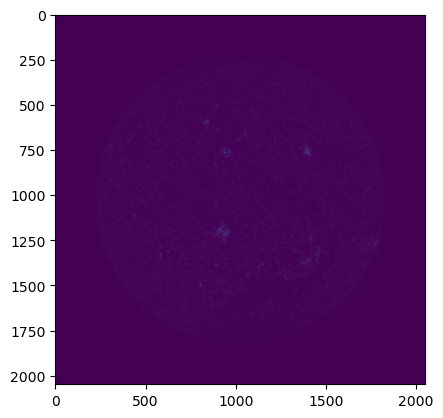

In [141]:
plt.imshow(a)

In [4]:
with open('D:\py_repo\EVE-spectrum-correction\Chapter4_v2\\basic_ops\eve_ops\data\daily_df.pkl', 'rb') as file:
    eve_daily_df=pickle.load(file)
    
eve_daily_df=eve_daily_df[eve_daily_df.index<pd.to_datetime('2014-05-25')]
eve_daily_df

,median_of_mean,median_of_stddev,median_of_amplitude,stddev_of_mean,stddev_of_stddev,stddev_of_amplitude,available_data
time,,,,,,,
2010-04-30,30.374138,0.028910,0.006518,0.000175,0.000076,0.000058,8570
2010-05-01,30.374133,0.028986,0.006556,0.000199,0.000070,0.000052,8579
2010-05-02,30.374000,0.029030,0.006503,0.000210,0.000070,0.000048,8579
2010-05-03,30.373922,0.029038,0.006513,0.000206,0.000102,0.000049,8640
2010-05-04,30.373876,0.029006,0.006656,0.000195,0.000092,0.000059,8578
...,...,...,...,...,...,...,...
2014-05-20,30.372114,0.031103,0.006697,0.000333,0.000145,0.000053,8583
2014-05-21,30.372141,0.031075,0.006630,0.000374,0.000141,0.000055,8581
2014-05-22,30.372299,0.030988,0.006609,0.000357,0.000127,0.000065,8582


In [5]:
coeff=np.load('aia_ops\\pixel_to_world\\coeff.npz')

In [25]:
coeff_x=cp.array(coeff['Tx_2048'])
coeff_y=cp.array(coeff['Ty_2048'])

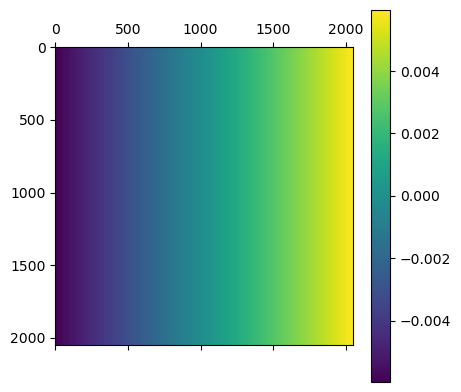

In [12]:
plt.matshow(coeff_x)
plt.colorbar()

In [23]:
%%timeit
np.sum(aia_df.loc[0]['image']*coeff_x)

15.9 ms ± 519 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
%%timeit
cp.sum(cp.array(aia_df.loc[0]['image'])*coeff_x)

1.07 ms ± 27.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
for i in aia_df['image']:

In [31]:
aia_df

,time,image,filename
0,2010-06-01 00:00:08.120,"[[0.003302, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001377,...",./data/AIA_1p5\aia_lev1_304a_2010_06_01t00_00_...
1,2010-06-02 00:05:38.120,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.276e-05...",./data/AIA_1p5\aia_lev1_304a_2010_06_02t00_05_...
2,2010-06-03 00:00:02.130,"[[0.0, 0.0, 3.535e-05, 0.0, 0.0, 5.496e-05, 0....",./data/AIA_1p5\aia_lev1_304a_2010_06_03t00_00_...
3,2010-06-04 00:00:02.130,"[[0.0, 0.0, 0.0, 0.0004733, 0.0, 0.0, 0.0, 0.0...",./data/AIA_1p5\aia_lev1_304a_2010_06_04t00_00_...
4,2010-06-05 00:00:05.500,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",./data/AIA_1p5\aia_lev1_304a_2010_06_05t00_00_...
...,...,...,...
1448,2014-05-20 00:00:07.120,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",./data/AIA_1p5\aia_lev1_304a_2014_05_20t00_00_...
1449,2014-05-21 00:00:07.120,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",./data/AIA_1p5\aia_lev1_304a_2014_05_21t00_00_...
1450,2014-05-22 00:00:07.120,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",./data/AIA_1p5\aia_lev1_304a_2014_05_22t00_00_...
1451,2014-05-23 00:00:07.120,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",./data/AIA_1p5\aia_lev1_304a_2014_05_23t00_00_...


In [151]:
# add a new col name 'x_ave' to aia_df, for each row, ave=np.sum(image*coeff_x)

# give me the code how to get the col
aia_df['x_ave']=aia_df['image'].apply(lambda x: (cp.sum(cp.array(x,dtype=cp.float64)*coeff_x)/cp.sum(cp.array(x,dtype=cp.float64))).get() )
aia_df['y_ave']=aia_df['image'].apply(lambda x: (cp.sum(cp.array(x,dtype=cp.float64)*coeff_y)/cp.sum(cp.array(x,dtype=cp.float64))).get())

In [89]:
eve_daily_df

,median_of_mean,median_of_stddev,median_of_amplitude,stddev_of_mean,stddev_of_stddev,stddev_of_amplitude,available_data
time,,,,,,,
2010-04-30,30.374138,0.028910,0.006518,0.000175,0.000076,0.000058,8570
2010-05-01,30.374133,0.028986,0.006556,0.000199,0.000070,0.000052,8579
2010-05-02,30.374000,0.029030,0.006503,0.000210,0.000070,0.000048,8579
2010-05-03,30.373922,0.029038,0.006513,0.000206,0.000102,0.000049,8640
2010-05-04,30.373876,0.029006,0.006656,0.000195,0.000092,0.000059,8578
...,...,...,...,...,...,...,...
2014-05-20,30.372114,0.031103,0.006697,0.000333,0.000145,0.000053,8583
2014-05-21,30.372141,0.031075,0.006630,0.000374,0.000141,0.000055,8581
2014-05-22,30.372299,0.030988,0.006609,0.000357,0.000127,0.000065,8582


In [37]:
# draw a scatter plot of x_ave vs eve_daily_df['median_of_mean']
# a thing to note is: the index of aia_df and eve_daily_df are not the same, 
# aia_df index is like 2010-06-01 00:00:08.120
# eve_daily_df index is like 2010-04-30



In [152]:
# turn the time col of aia_df of: 2010-06-01 00:00:08.120    into 2010-06-01
temp_aia_df=aia_df.copy()
temp_aia_df['time']=temp_aia_df['time'].apply(lambda x: pd.to_datetime(x.date()))
temp_aia_df.set_index('time',inplace=True)
temp_aia_df

,image,filename,x_ave,y_ave
time,,,,
2010-06-01,"[[0.003302, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001377,...",./data/AIA_1p5\aia_lev1_304a_2010_06_01t00_00_...,0.000011,0.000064
2010-06-02,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.276e-05...",./data/AIA_1p5\aia_lev1_304a_2010_06_02t00_05_...,0.000039,0.000053
2010-06-03,"[[0.0, 0.0, 3.535e-05, 0.0, 0.0, 5.496e-05, 0....",./data/AIA_1p5\aia_lev1_304a_2010_06_03t00_00_...,0.000036,0.000065
2010-06-04,"[[0.0, 0.0, 0.0, 0.0004733, 0.0, 0.0, 0.0, 0.0...",./data/AIA_1p5\aia_lev1_304a_2010_06_04t00_00_...,0.000066,0.000071
2010-06-05,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",./data/AIA_1p5\aia_lev1_304a_2010_06_05t00_00_...,NaN,NaN
...,...,...,...,...
2014-05-20,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",./data/AIA_1p5\aia_lev1_304a_2014_05_20t00_00_...,0.000157,-0.000151
2014-05-21,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",./data/AIA_1p5\aia_lev1_304a_2014_05_21t00_00_...,0.000132,-0.000192
2014-05-22,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",./data/AIA_1p5\aia_lev1_304a_2014_05_22t00_00_...,0.000116,-0.000187


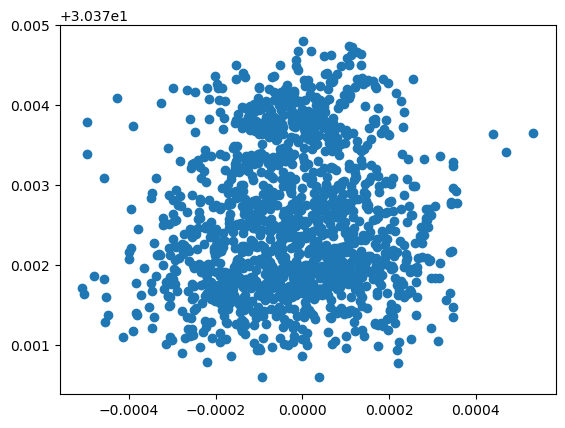

In [153]:
#find the common index of temp_aia_df and eve_daily_df
# draw a scatter plot of x_ave vs eve_daily_df['median_of_mean']

common_index=temp_aia_df.index.intersection(eve_daily_df.index)
fig, ax = plt.subplots()
ax.scatter(temp_aia_df.loc[common_index]['x_ave'],eve_daily_df.loc[common_index]['median_of_mean'])


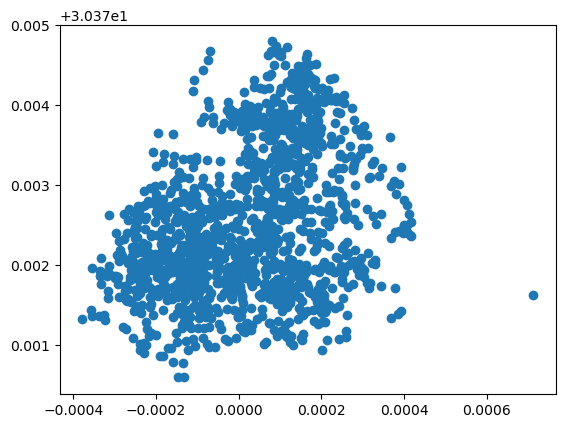

In [154]:
fig,ax=plt.subplots()
ax.scatter(temp_aia_df.loc[common_index]['y_ave'],eve_daily_df.loc[common_index]['median_of_mean'])

In [157]:
timerange=pd.date_range('2012-7-22','2012-12-25',freq='D')

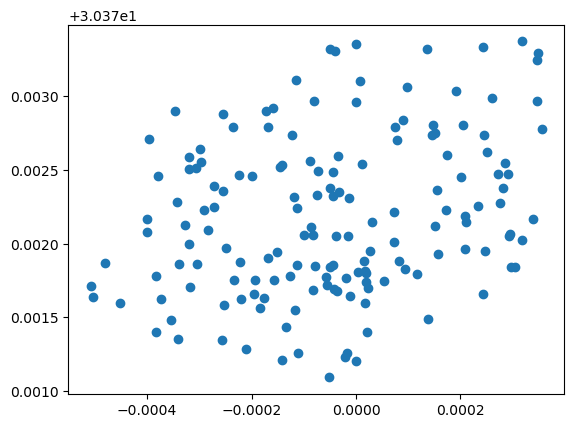

In [158]:
fig,ax=plt.subplots()
ax.scatter(temp_aia_df.loc[timerange]['x_ave'],eve_daily_df.loc[timerange]['median_of_mean'])

In [163]:
# do a linear regression: temp_aia_df.loc[timerange]['x_ave'] and eve_daily_df.loc[timerange]['median_of_mean']
# give me the code instead of comment
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(temp_aia_df.loc[timerange]['y_ave']**2,eve_daily_df.loc[timerange]['median_of_mean'])
# print the complete result
print('slope: ',slope)
print('intercept: ',intercept)
print('r_value: ',r_value)
print('p_value: ',p_value)
print('std_err: ',std_err)

slope:  -154.12338485100247
intercept:  30.372188432225297
r_value:  -0.005311459436664458
p_value:  0.9473610803645816
std_err:  2330.6802393223597


In [101]:
np.corrcoef(temp_aia_df.loc[common_index]['x_ave'].values,eve_daily_df.loc[common_index]['median_of_mean'].values)


array([[nan, nan],
       [nan, nan]])

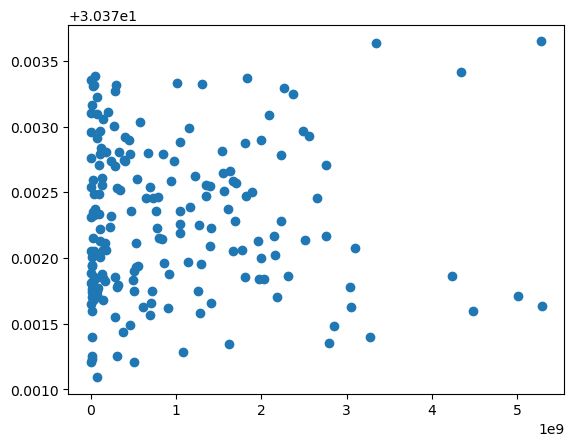

In [55]:
fig,ax=plt.subplots()
ax.scatter(temp_aia_df.loc[timerange]['x_ave']**2,eve_daily_df.loc[timerange]['median_of_mean'])